* band pass filter for theta, alpha, beta, and gamma -> single epoch
* compute lcmv
* epochs in source space
* envelope on single epoch (envelope = abs(hilbert))
* average envelopes

In [1]:
import mne
import os
import re

os.environ['MNE_3D_OPTION_ANTIALIAS']='false' # to make visualization work

current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)

from utils import check_paths

import imageio.v3 as iio

import seaborn as sns

In [ ]:
# ONE CELL THAT RULES THEM ALL

# directories to work with
subjects_dir = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\subjects'
mris_dir = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\mri'
fsaverage_src_path = os.path.join(mris_dir, 'fsaverage', 'bem', 'fsaverage-ico-5-src.fif')

# dirs to test SR on single subject
subject = 'sub2'
subject_dir = os.path.join(subjects_dir, subject)
# mri_path = os.path.join(mris_dir, subject)
epochs_dir = os.path.join(subject_dir, 'epochs')
epochs_path = os.path.join(epochs_dir, os.listdir(epochs_dir)[0])
trans_path = os.path.join(mris_dir, subject, f'{subject}_trans')

# read epochs and trans files
epochs = mne.read_epochs(epochs_path).pick_types(meg='mag')
info = epochs.info
trans = mne.read_trans(trans_path)

# set frequency bands
epochs_theta = epochs.copy().filter(4., 8.).apply_hilbert(envelope=True)
evoked_theta = epochs_theta.average()

# create source space
src = mne.setup_source_space(
    subject, spacing='oct6', add_dist='patch',
    subjects_dir=mris_dir)
print(src)

# create BEM model
model = mne.make_bem_model(subject=subject, ico=4, #? ico downsampling
                           conductivity=[0.3], # for single layer - suitable for MEG data
                           subjects_dir=mris_dir)
bem = mne.make_bem_solution(model)

# compute the leadfield matrix / forward operator
fwd = mne.make_forward_solution(info, trans=trans, src=src, bem=bem,
                                meg=True, eeg=False, mindist=5.0, n_jobs=None,
                                verbose=True)
print(fwd)

In [ ]:
# comparing data covariance matrices from full spectrum epochs and in various freq bands
#! ASKED TOMMASO: WAITING FOR THE ANSWER

epochs_alpha = epochs.copy().filter(8., 15.).apply_hilbert(envelope=True)
epochs_beta = epochs.copy().filter(15., 30.).apply_hilbert(envelope=True)
epochs_gamma = epochs.copy().filter(30., 60.).apply_hilbert(envelope=True)
evoked_alpha = epochs_alpha.average()
evoked_beta = epochs_beta.average()
evoked_gamma = epochs_gamma.average()

In [50]:
data_cov = mne.compute_covariance(epochs, tmin=0.01, tmax=1.5,
                                  method='empirical')
data_cov_theta = mne.compute_covariance(epochs_theta, tmin=0.01, tmax=1.5,
                                  method='empirical')
data_cov_alpha = mne.compute_covariance(epochs_alpha, tmin=0.01, tmax=1.5,
                                  method='empirical')
data_cov_beta = mne.compute_covariance(epochs_beta, tmin=0.01, tmax=1.5,
                                  method='empirical')
data_cov_gamma = mne.compute_covariance(epochs_gamma, tmin=0.01, tmax=1.5,
                                  method='empirical')


Computing rank from data with rank=None
    Using tolerance 8.4e-09 (2.2e-16 eps * 102 dim * 3.7e+05  max singular value)
    Estimated rank (mag): 102
Found multiple SSS records. Using the first.
    MAG: rank 102 computed from 102 data channels with 0 projectors
Reducing data rank from 102 -> 102
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 62790
[done]


C:\Users\CCDM\AppData\Local\Temp\ipykernel_7888\3017915172.py:1: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (102 > 80). Consider setting rank to "auto" or setting it explicitly as an integer.
  data_cov = mne.compute_covariance(epochs, tmin=0.01, tmax=1.5,


Computing rank from data with rank=None
    Using tolerance 1e-08 (2.2e-16 eps * 102 dim * 4.6e+05  max singular value)
    Estimated rank (mag): 102
Found multiple SSS records. Using the first.
    MAG: rank 102 computed from 102 data channels with 0 projectors
Reducing data rank from 102 -> 102
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 62790
[done]


C:\Users\CCDM\AppData\Local\Temp\ipykernel_7888\3017915172.py:3: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (102 > 80). Consider setting rank to "auto" or setting it explicitly as an integer.
  data_cov_theta = mne.compute_covariance(epochs_theta, tmin=0.01, tmax=1.5,


Computing rank from data with rank=None
    Using tolerance 1.1e-08 (2.2e-16 eps * 102 dim * 5e+05  max singular value)
    Estimated rank (mag): 102
Found multiple SSS records. Using the first.
    MAG: rank 102 computed from 102 data channels with 0 projectors
Reducing data rank from 102 -> 102
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 62790
[done]


C:\Users\CCDM\AppData\Local\Temp\ipykernel_7888\3017915172.py:5: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (102 > 80). Consider setting rank to "auto" or setting it explicitly as an integer.
  data_cov_alpha = mne.compute_covariance(epochs_alpha, tmin=0.01, tmax=1.5,


Computing rank from data with rank=None
    Using tolerance 7.4e-09 (2.2e-16 eps * 102 dim * 3.3e+05  max singular value)
    Estimated rank (mag): 102
Found multiple SSS records. Using the first.
    MAG: rank 102 computed from 102 data channels with 0 projectors
Reducing data rank from 102 -> 102
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 62790
[done]


C:\Users\CCDM\AppData\Local\Temp\ipykernel_7888\3017915172.py:7: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (102 > 80). Consider setting rank to "auto" or setting it explicitly as an integer.
  data_cov_beta = mne.compute_covariance(epochs_beta, tmin=0.01, tmax=1.5,


Computing rank from data with rank=None
    Using tolerance 5e-09 (2.2e-16 eps * 102 dim * 2.2e+05  max singular value)
    Estimated rank (mag): 102
Found multiple SSS records. Using the first.
    MAG: rank 102 computed from 102 data channels with 0 projectors
Reducing data rank from 102 -> 102
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 62790
[done]


C:\Users\CCDM\AppData\Local\Temp\ipykernel_7888\3017915172.py:9: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (102 > 80). Consider setting rank to "auto" or setting it explicitly as an integer.
  data_cov_gamma = mne.compute_covariance(epochs_gamma, tmin=0.01, tmax=1.5,


Computing rank from covariance with rank=None
    Using tolerance 5e-14 (2.2e-16 eps * 102 dim * 2.2  max singular value)
    Estimated rank (mag): 80
Found multiple SSS records. Using the first.
    MAG: rank 80 computed from 102 data channels with 0 projectors


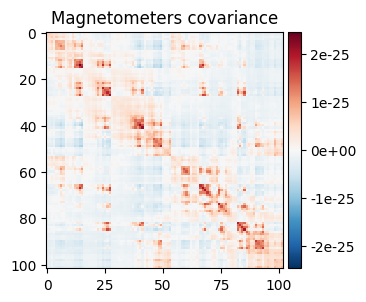

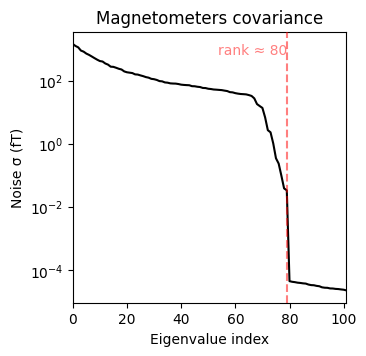

Computing rank from covariance with rank=None
    Using tolerance 7.7e-14 (2.2e-16 eps * 102 dim * 3.4  max singular value)
    Estimated rank (mag): 102
Found multiple SSS records. Using the first.
    MAG: rank 102 computed from 102 data channels with 0 projectors


C:\Users\CCDM\AppData\Local\Temp\ipykernel_7888\1736046012.py:2: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (102 > 80). Consider setting rank to "auto" or setting it explicitly as an integer.
  data_cov_theta.plot(epochs_theta.info)


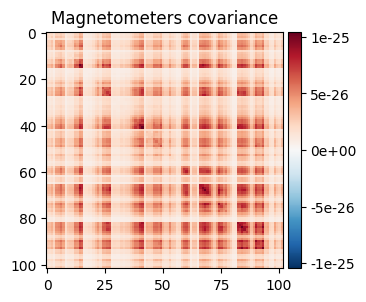

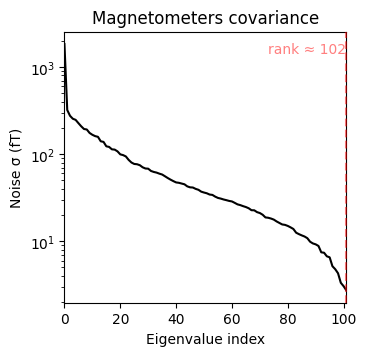

Computing rank from covariance with rank=None
    Using tolerance 8.8e-14 (2.2e-16 eps * 102 dim * 3.9  max singular value)
    Estimated rank (mag): 102
Found multiple SSS records. Using the first.
    MAG: rank 102 computed from 102 data channels with 0 projectors


C:\Users\CCDM\AppData\Local\Temp\ipykernel_7888\1736046012.py:3: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (102 > 80). Consider setting rank to "auto" or setting it explicitly as an integer.
  data_cov_alpha.plot(epochs_alpha.info)


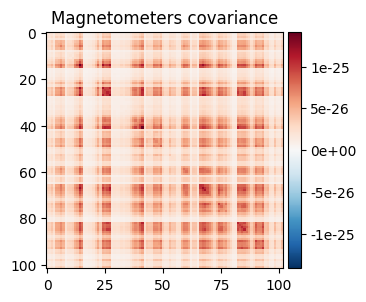

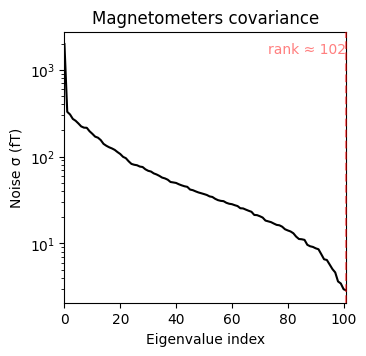

Computing rank from covariance with rank=None
    Using tolerance 3.9e-14 (2.2e-16 eps * 102 dim * 1.7  max singular value)
    Estimated rank (mag): 102
Found multiple SSS records. Using the first.
    MAG: rank 102 computed from 102 data channels with 0 projectors


C:\Users\CCDM\AppData\Local\Temp\ipykernel_7888\1736046012.py:4: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (102 > 80). Consider setting rank to "auto" or setting it explicitly as an integer.
  data_cov_beta.plot(epochs_beta.info)


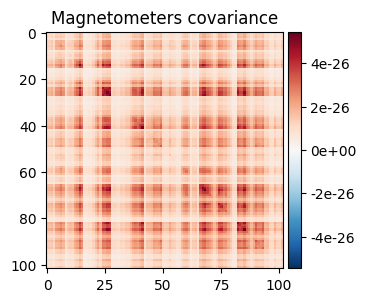

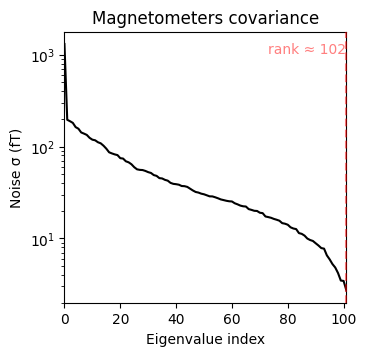

Computing rank from covariance with rank=None
    Using tolerance 1.7e-14 (2.2e-16 eps * 102 dim * 0.76  max singular value)
    Estimated rank (mag): 102
Found multiple SSS records. Using the first.
    MAG: rank 102 computed from 102 data channels with 0 projectors


C:\Users\CCDM\AppData\Local\Temp\ipykernel_7888\1736046012.py:5: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (102 > 80). Consider setting rank to "auto" or setting it explicitly as an integer.
  data_cov_gamma.plot(epochs_gamma.info)


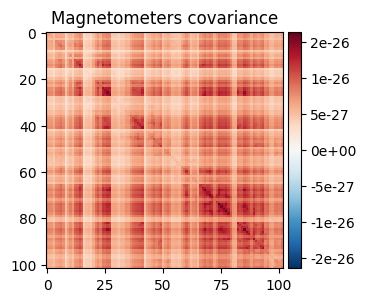

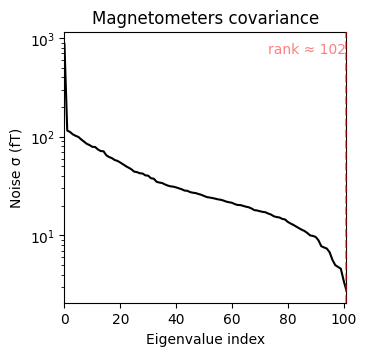

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [51]:
data_cov.plot(epochs.info)
data_cov_theta.plot(epochs_theta.info)
data_cov_alpha.plot(epochs_alpha.info)
data_cov_beta.plot(epochs_beta.info)
data_cov_gamma.plot(epochs_gamma.info)

In [ ]:
# comparing forward solution from epochs (magnetometers) with fwd from epochs (magnetometers) filtered in theta
#! NO DIFFERENCE FOUND
#! fwd from epochs can be used for all frequency bands

from deepdiff import DeepDiff # Deep Difference of dictionaries, iterables, strings and almost any other object. It will recursively look for all the changes.

fwd = mne.make_forward_solution(info, trans=trans, src=src, bem=bem,
                                meg=True, eeg=False, mindist=5.0, n_jobs=None,
                                verbose=True)

fwd_theta = mne.make_forward_solution(epochs_theta.info, trans=trans, src=src, bem=bem,
                                meg=True, eeg=False, mindist=5.0, n_jobs=None,
                                verbose=True)
print(fwd)
print(fwd_theta)
DeepDiff(fwd, fwd_theta)

Computing rank from covariance with rank=None
    Using tolerance 5e-14 (2.2e-16 eps * 102 dim * 2.2  max singular value)
    Estimated rank (mag): 80
Found multiple SSS records. Using the first.
    MAG: rank 80 computed from 102 data channels with 0 projectors


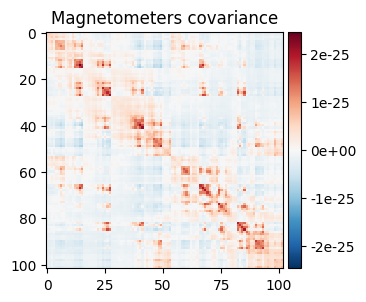

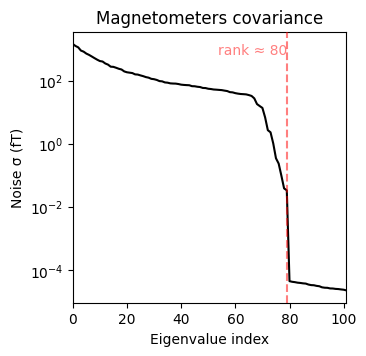

Computing rank from covariance with rank=None
    Using tolerance 7.7e-14 (2.2e-16 eps * 102 dim * 3.4  max singular value)
    Estimated rank (mag): 102
Found multiple SSS records. Using the first.
    MAG: rank 102 computed from 102 data channels with 0 projectors


C:\Users\CCDM\AppData\Local\Temp\ipykernel_1576\1565178427.py:2: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (102 > 80). Consider setting rank to "auto" or setting it explicitly as an integer.
  data_cov_theta.plot(epochs_theta.info)


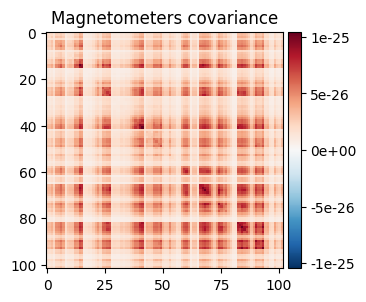

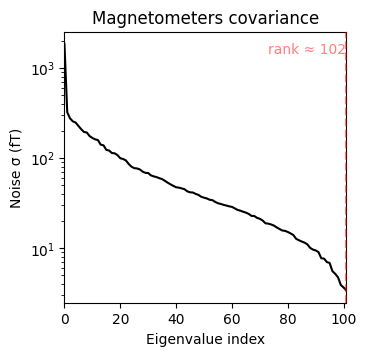

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [156]:
data_cov.plot(epochs.info)
data_cov_theta.plot(epochs_theta.info)

In [ ]:
data_cov_theta = mne.compute_covariance(epochs_theta, tmin=0.01, tmax=1.5,
                                  method='auto')
data_cov_theta.plot(epochs_theta.info)

Computing rank from data with rank=None
    Using tolerance 8.4e-09 (2.2e-16 eps * 102 dim * 3.7e+05  max singular value)
    Estimated rank (mag): 102
Found multiple SSS records. Using the first.
    MAG: rank 102 computed from 102 data channels with 0 projectors
Reducing data rank from 102 -> 102
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 62790


C:\Users\CCDM\AppData\Local\Temp\ipykernel_7888\4073558410.py:2: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (102 > 80). Consider setting rank to "auto" or setting it explicitly as an integer.
  data_cov = mne.compute_covariance(epochs, tmin=0.01, tmax=1.5,


[done]
Computing rank from covariance with rank=None
    Using tolerance 5e-14 (2.2e-16 eps * 102 dim * 2.2  max singular value)
    Estimated rank (mag): 80
Found multiple SSS records. Using the first.
    MAG: rank 80 computed from 102 data channels with 0 projectors


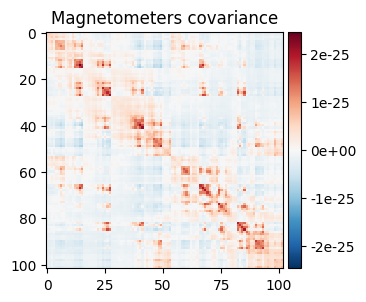

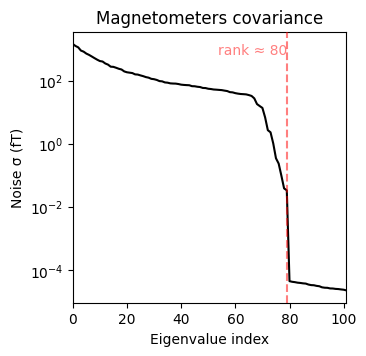

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [3]:
# compute data covariance
data_cov = mne.compute_covariance(epochs, tmin=0.01, tmax=1.5,
                                  method='empirical')
data_cov.plot(epochs.info)

In [ ]:
# compute noise covariance from epochs (post-stimulus)
noise_cov_post = mne.compute_covariance(epochs, tmin=3., tmax=3.75,
                                   method='empirical')
noise_cov_post.plot(epochs.info)

In [ ]:
# compute noise covariance from epochs (pre-stimulus)
noise_cov_pre = mne.compute_covariance(epochs, tmin=-1., tmax=-0.01,
                                   method='empirical')
noise_cov_pre.plot(epochs.info)

Opening raw data file D:\Ekaterina_Voevodina\memory_formation\data\empty_room\empty_room_tsss.fif...
Isotrak not found
    Range : 45000 ... 329999 =     45.000 ...   329.999 secs
Ready.
Reading 0 ... 284999  =      0.000 ...   284.999 secs...


C:\Users\CCDM\AppData\Local\Temp\ipykernel_7888\3022028118.py:3: RuntimeWarning: This filename (D:\Ekaterina_Voevodina\memory_formation\data\empty_room\empty_room_tsss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  empty_room_file =  mne.io.read_raw_fif(empty_room_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 95.00 Hz)
- Filter length: 1321 samples (6.605 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)



[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Using up to 1425 segments


[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    0.2s finished


Number of samples used : 57000
[done]
Computing rank from covariance with rank=None
    Using tolerance 1.7e-15 (2.2e-16 eps * 102 dim * 0.075  max singular value)
    Estimated rank (mag): 68
Found multiple SSS records. Using the first.
    MAG: rank 68 computed from 102 data channels with 0 projectors


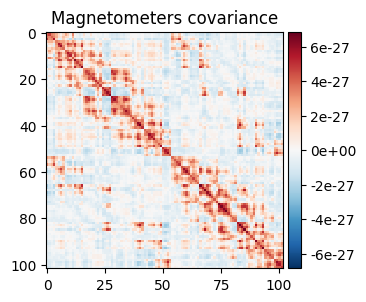

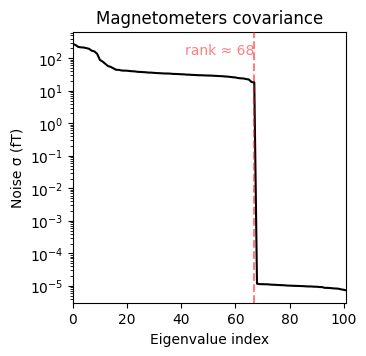

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [4]:
# compute noise covariance from empty room
empty_room_path = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\empty_room\\empty_room_tsss.fif'
empty_room_file =  mne.io.read_raw_fif(empty_room_path, preload=True)
empty_room_file = empty_room_file.resample(200)


empty_room_filt = empty_room_file.copy()\
    .filter(l_freq=.5, h_freq=90)\
    .notch_filter(50) # filter data

noise_cov_er = mne.compute_raw_covariance(
    empty_room_filt, tmin=0, tmax=None)
noise_cov_er.plot(epochs.info)

In [ ]:
#! DIRTY CODE
# compute spatial LCMV filter using info from EPOCHS / THETA EPOCHS / THETA EVOKED
#! NO DIFFERENCE
#! USE INFO FROM EPOCHS

filters_epochsi = mne.beamformer.make_lcmv(info, fwd, data_cov, reg=0.05,
                    noise_cov=noise_cov_post, pick_ori='max-power',
                    weight_norm='unit-noise-gain', rank=None)

filters_epo_theta_i = mne.beamformer.make_lcmv(epochs_theta.info, fwd, data_cov, reg=0.05,
                    noise_cov=noise_cov_post, pick_ori='max-power',
                    weight_norm='unit-noise-gain', rank=None)

filters_evo_theta_i = mne.beamformer.make_lcmv(evoked_theta.info, fwd, data_cov, reg=0.05,
                    noise_cov=noise_cov_post, pick_ori='max-power',
                    weight_norm='unit-noise-gain', rank=None)

DeepDiff(filters_epochsi.values(), filters_epo_theta_i.values())
DeepDiff(filters_epo_theta_i.values(), filters_evo_theta_i.values())


In [ ]:
filters = mne.beamformer.make_lcmv(info, fwd, data_cov, reg=0.05,
                    noise_cov=noise_cov_er, pick_ori='max-power',
                    weight_norm='unit-noise-gain', rank='info')


In [89]:
len(stc_epo_theta_i) == len(stc_evo_theta_i)

True

In [63]:
stc_epochsi[0].data

array([[-0.64086887, -0.30548284, -0.82807553, ...,  0.54243137,
        -2.21143051, -0.71538422],
       [ 0.74867699,  0.00676806,  0.52229854, ..., -0.2050822 ,
         0.07782822,  0.27299651],
       [ 0.20335127,  0.39583998, -0.00368249, ...,  0.11890926,
        -1.77297996, -0.96978129],
       ...,
       [ 0.37447847,  0.8137845 , -0.07126451, ...,  1.32157997,
         0.03290752, -0.31101019],
       [ 0.08765928,  0.14271318, -0.28906334, ..., -0.81165094,
        -1.6689328 , -1.28902103],
       [ 0.19398038,  1.06244294,  0.09604558, ..., -0.56479864,
        -0.55962119, -1.1833501 ]])

In [67]:
import matplotlib.pyplot as plt

In [90]:
array_epochsi = stc_epochsi[0].data
array_epo_theta_i = stc_epo_theta_i[0].data
array_evo_theta_i = stc_evo_theta_i[0].data

In [87]:
array.mean(axis=1).shape

(8192,)

In [84]:
array.shape

(8192, 1100)

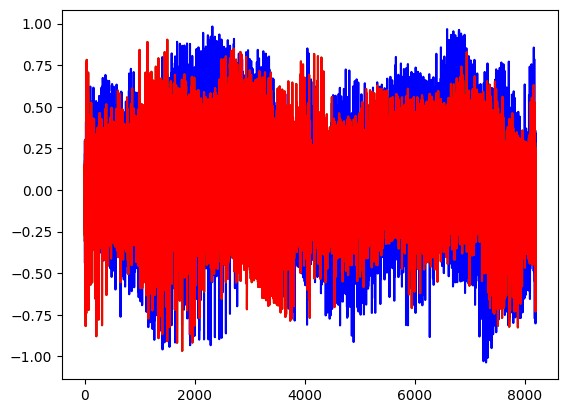

In [96]:
f1 = plt.plot(array_epochsi.mean(axis=1), 'b')
f2 = plt.plot(array_epo_theta_i.mean(axis=1), 'g')
f3 = plt.plot(array_evo_theta_i.mean(axis=1), 'r')

plt.show()

 ...]

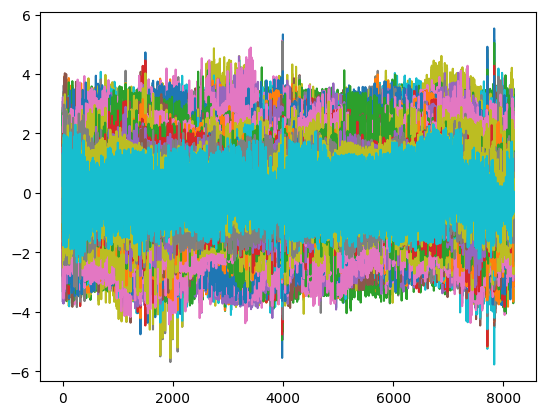

In [79]:
plt.plot(stc_epo_theta_i[0].data)

In [62]:
print(stc_epochsi[0])
print(stc_epo_theta_i[0])
print(stc_evo_theta_i[0])

<SourceEstimate | 8192 vertices, subject : sub2, tmin : -1500.0 (ms), tmax : 3995.0 (ms), tstep : 5.0 (ms), data shape : (8192, 1100), ~68.8 MB>
<SourceEstimate | 8192 vertices, subject : sub2, tmin : -1500.0 (ms), tmax : 3995.0 (ms), tstep : 5.0 (ms), data shape : (8192, 1100), ~68.8 MB>
<SourceEstimate | 8192 vertices, subject : sub2, tmin : -1500.0 (ms), tmax : 3995.0 (ms), tstep : 5.0 (ms), data shape : (8192, 1100), ~68.8 MB>


In [ ]:
stc = mne.beamformer.apply_lcmv_epochs(epochs_theta, filters)

In [51]:
len(filters_epochsi.values()) == len(filters_evo_theta_i.values())

True

In [34]:
filters_epo_theta_i

<Beamformer | LCMV, subject "sub2", 8192 vert, 306 ch, max-power ori, unit-noise-gain norm, matrix inversion, rank 80>

In [ ]:
#? INVESTIGATING THE BEAMFORMER
#! DIRTY CODE
# compute spatial LCMV filter on EPOCHS
filters_pre = mne.beamformer.make_lcmv(info, fwd, data_cov, reg=0.05,
                    noise_cov_pre=noise_cov, pick_ori='max-power',
                    weight_norm='unit-noise-gain', rank=None)

filters_post = mne.beamformer.make_lcmv(info, fwd, data_cov, reg=0.05,
                    noise_cov_post=noise_cov, pick_ori='max-power',
                    weight_norm='unit-noise-gain', rank=None)
# apply spatial LCMV filter to EPOCHS
# stc = mne.beamformer.apply_lcmv_epochs(epochs_theta, filters)

In [ ]:
# compute spatial LCMV filter on EVOKED data

# part of the epoch is used for noise covariance
filters = mne.beamformer.make_lcmv(evoked_theta.info, fwd, data_cov, reg=0.05,
                    noise_cov=noise_cov, pick_ori='max-power',
                    weight_norm='unit-noise-gain', rank=None)

In [ ]:
# compute spatial LCMV filter

# part of the epoch is used for noise covariance
# filters = mne.beamformer.make_lcmv(evoked_theta.info, fwd, data_cov, reg=0.05,
#                     noise_cov=noise_cov, pick_ori='max-power',
#                     weight_norm='unit-noise-gain', rank=None)

# in case empty room is used for noise covariance
filters = mne.beamformer.make_lcmv(evoked_theta.info, fwd, data_cov, reg=0.05,
                    noise_cov=noise_cov, pick_ori='max-power',
                    weight_norm='unit-noise-gain', rank='info', reduce_rank=True)

# reg=0.05 loading the diagonal of the covariance matrix with 5% of the sensor power

In [40]:
# apply spatial LCMV filter to evoked data
stc = mne.beamformer.apply_lcmv(evoked_theta, filters)

In [ ]:
stc = mne.beamformer.apply_lcmv_epochs(epochs_theta, filters)

In [ ]:
#! find a way to take the envelope of the signal
#! check matrices of different filters for averaged signal or for one epoch
#!!!!!!!!!!
stc_hits = mne.beamformer.apply_lcmv(epochs['hits'].filter(4., 8.).average(), filters) # dipoles x time for condition 1
stc_miss = mne.beamformer.apply_lcmv(epochs['miss'].filter(4., 8.).average(), filters) # dipoles x time for condition 2
stc_diff = stc_hits - stc_miss

In [ ]:
stc_hilbert_evoked = mne.beamformer.apply_lcmv(epochs_theta.apply_hilbert(envelope=True).average(), filters)


In [ ]:
df = stc[0].to_data_frame().drop(['subject', 'time'], axis=1)

In [ ]:

sns.heatmap(df.iloc[[0]], annot=True)

In [44]:
#! Chnge the limits for the figure!!!
#!!!!!!!!!!!!!!!
lims = [0, 0.45, 6]
kwargs = dict(src=src, subject=subject, subjects_dir=mris_dir,
              initial_time=None, verbose=True)

fig1 = stc.plot(hemi='both', views=['dorsal', 'ventral'], clim=dict(kind='value', pos_lims=lims), **kwargs)


OverflowError: argument 1 overflowed: value must be in the range -2147483648 to 2147483647

In [ ]:
filedir = os.path.join(subject_dir, 'movie', 'theta')
check_paths(filedir)

In [ ]:
# visualize the sources and save the movie
# launch only for GROUP analysis

filepath = os.path.join(filedir, 'sources_all_post.mp4')

%matplotlib inline
fig = stc.plot(hemi='both', views=['dorsal', 'ventral'], clim=dict(kind='value', pos_lims=lims), **kwargs)
fig.save_movie(filename=filepath, time_dilation=4.0, tmin=-1.0, tmax=2.0)

In [14]:
type(stc[0])
stc[0]

<SourceEstimate | 8192 vertices, subject : sub2, tmin : -1500.0 (ms), tmax : 3995.0 (ms), tstep : 5.0 (ms), data shape : (8192, 1100), ~68.8 MB>

In [23]:
fig = stc.plot(hemi='both', views=['dorsal', 'ventral'], clim=dict(kind='value', pos_lims=lims), **kwargs)


OverflowError: argument 1 overflowed: value must be in the range -2147483648 to 2147483647